In [10]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm
import scipy as sp

In [117]:
def eval_and_reduce_cc(len_marks_1):
    res = np.zeros(len_marks_1)
    res[0] = len_marks_1
    res[1:] = np.arange(2, 2*(len_marks_1), 2)[::-1]
    return res

def erf(n):
    return sp.special.erf(n)

def inc_gamma(a, x):
    return sp.special.gamma(a)*sp.special.gammaincc(a, x)

# SAME AS "FIXED", just copy pasted to ensure it matches
def calc_sf2_nuclear_tower(chrom, k_vec = np.logspace(-3, -1, 30)):
    # calculates sf2 using rank 1 monomer correlation tensor 
    # incorporates shift in scaling due to looping behavior in nucleus
    
    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    M2_AA= eval_and_reduce_cc(len(poly_marks[0]))
    
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
    
    S2_AA_arr = np.zeros(nk)

    
    bp_per_nuc = 190 # bp per nucleosome
    nm_per_bp = 0.34 
    lower_cutoff = 28.89 * 1000 # bp, s1*, from Rubenstein
    upper_cutoff = 399.12 * 1000 # bp, s2*
#     upper_cutoff = lower_cutoff
    
    lc_kuhn = lower_cutoff * (nm_per_bp) * (1/b) # converted to nm, then kuhn lengths
    uc_kuhn = upper_cutoff * (nm_per_bp) * (1/b) 

    for i, k in enumerate(k_vec):
        C = np.zeros(M)
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2
        delta = np.arange(0, M, 1)
        
        
        # j1 = j2, s1 > s2
        
        
        index = 0#(j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 

        C[0] += debye
        

        # if j1 - j2 < lower_cutoff
        
        
        index = (np.arange(0, M, 1) * bp_per_nuc <= lower_cutoff) * (np.arange(0, M, 1) != 0) 
        constant = np.exp(-x_m*delta)
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) 

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral        
        
        
        # intermediate case, 2/3 scaling
        
        
        index = (np.arange(0, M, 1) * bp_per_nuc > lower_cutoff) * (np.arange(0, M, 1) * bp_per_nuc <= upper_cutoff)
        dlta = delta[index]

        x_m = (1/6) * N_m**(2/3) * b**2 * k**2 * (lc_kuhn)**(1/3)
        

        gammas = -6*inc_gamma(2, dlta**(2/3)*x_m) + 3*inc_gamma(2, (dlta-1)**(2/3)*x_m) \
                + 3*inc_gamma(2, (dlta+1)**(2/3)*x_m)
        erfs = np.pi**0.5 * (dlta - 1)*x_m**(3/2)*erf((dlta-1)**(1/3)*x_m**0.5) \
                - 2*np.pi**0.5 * (dlta)*x_m**(3/2)*erf((dlta)**(1/3)*x_m**0.5) \
                + np.pi**0.5 * (dlta)*x_m**(3/2)*erf((dlta+1)**(1/3)*x_m**0.5) \
                + np.pi**0.5 * x_m**(3/2)*erf((dlta+1)**(1/3)*x_m**0.5)
        neiths = -2*(dlta)**(2/3)*x_m*np.exp(-dlta**(2/3)*x_m) - 2*np.exp(-dlta**(2/3)*x_m)\
                + (dlta - 1)**(2/3) * x_m * np.exp(-(dlta-1)**(2/3)*x_m) \
                + (dlta + 1)**(2/3) * x_m * np.exp(-(dlta+1)**(2/3)*x_m) \
                + np.exp(-(dlta-1)**(2/3)*x_m) + np.exp(-(dlta+1)**(2/3)*x_m)


        integral = 3/(4*x_m**3) * (gammas + erfs + neiths)
#         integral = ((np.exp(x_m)-1)**2 *  np.exp(-(delta**(2/3)+1)*x_m)  ) /x_m**2   # rough scaling implementation

        num_leading_zeros = np.sum((np.arange(0, M, 1) * bp_per_nuc <= lower_cutoff))
        num_trailing_zeros = np.sum((np.arange(0, M, 1) * bp_per_nuc > upper_cutoff))
        
        integral = np.pad(integral, (num_leading_zeros,num_trailing_zeros))
    
        C[np.where((index) != 0)] += integral[np.where((index) != 0)]
        
        
        # if j1 - j2 > upper cutoff -> 1 scaling
        
        
        index = (np.arange(0, M, 1) * bp_per_nuc > upper_cutoff)
        x_m = (1/6) * N_m * b**2 * k**2 * (lc_kuhn/uc_kuhn)**(1/3)
        constant = np.exp(-x_m*delta)
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) 

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
        

        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)

        
    return S2_AA_arr*N**2

def calc_sf2_chromo_shlk(chrom, k_vec = np.logspace(-3, -1, 30)):
    # calculates sf2 using rank 1 monomer correlation tensor 
    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    M2_AA= eval_and_reduce_cc(len(poly_marks[0]))
    
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
    
    S2_AA_arr = np.zeros(nk)

    for i, k in enumerate(k_vec):
        C = np.zeros(M)
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = 0#(j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 

    #     C[np.where((index) != 0)] += debye
        C[0] += debye

        #j1 > j2, s1 s2 any
        index = np.arange(0, M, 1)#(j1 > j2) #index = del!
        constant = np.exp(-x_m*index)
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral

        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)

    return S2_AA_arr*N**2

In [12]:
# load sf mat

# ID = -17.49
# ID = -10.74  #cross 3
# ID = -13.74  #cross 1.5
# ID = -16.74  #cross 0
# ID = -19.74  #cross -1.5
# ID = -22.74  #cross -3

# ID = -21.54  #cross -3
# ID = -21.64  #cross -3
# ID = -16.9

# ID = -13.88
# looping = "nuc, "

ID = -5.88
looping = "gaus, "

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [114]:
b

40

In [4]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[-4  4]
 [ 4 -4]]
phi_c: 
0.4
mu max, min, del_mu:
0.1 -9 0.1
k logspace min, max, tot num:
-2.5 -1 30


In [13]:
%%time
homo_nuc_tower = calc_sf2_nuclear_tower(chrom, k_vec)

CPU times: total: 141 ms
Wall time: 810 ms


In [118]:
homo_gaus = calc_sf2_chromo_shlk(chrom, k_vec)

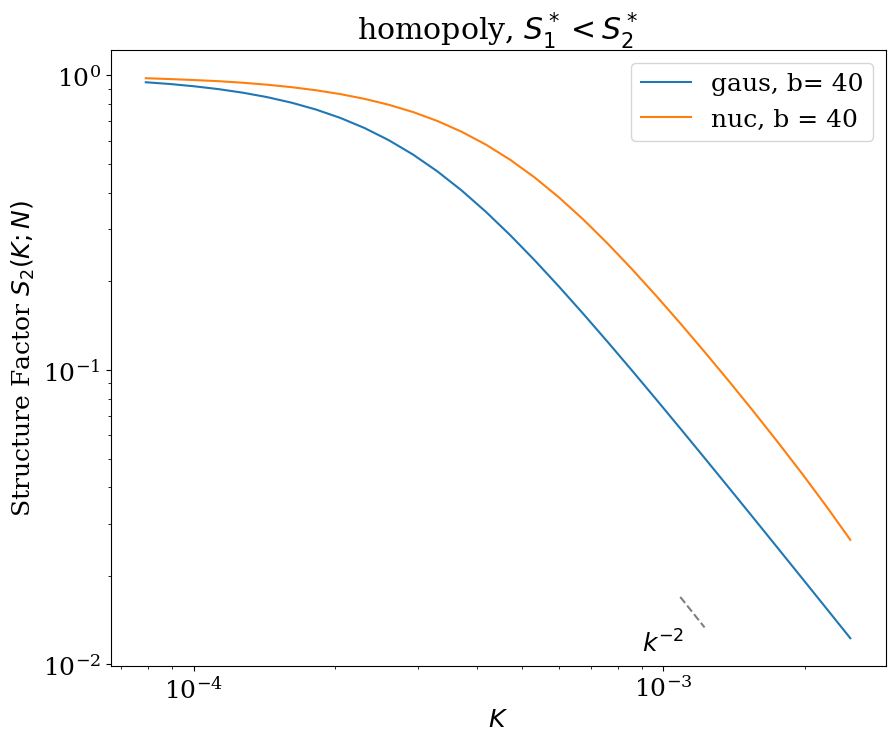

In [119]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
alh = 1
plt.plot(k_vec, homo_gaus/N**2, label = "gaus, b= " + str(b), linestyle = "-", alpha = alh)
plt.plot(k_vec, homo_nuc_tower/N**2, label = "nuc, b = " + str(b), linestyle = "-", alpha = alh)

# plt.text(5, 0.0035, '$k^{-2}$')
# plt.text(5.5, 0.0015, '$k^{-2}$')

plt.xscale('log')
plt.yscale('log')

plt.title("homopoly, $S_1^* < S_2^*$")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
# plt.xlim((1e-3, 1e2))

low = 22
high = 24
plt.plot(k_vec[low:high], 0.00000002*k_vec[low:high]**-2, linestyle = "--", color = "grey")
plt.text(.0009, 0.011, '$k^{-2}$')

plt.legend()

In [120]:
phi_c_array = np.arange(.1,.91,0.01)#
chi_array = np.arange(0,1,0.01)#



A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome
vol_solv = 1 

min_eigval_arr_ps = np.zeros((len(chi_array),len(phi_c_array), len(k_vec)))
min_eigval_arr_allk_ps = np.zeros((len(chi_array),len(phi_c_array)))

min_eigval_arr_ps_gaus = np.zeros((len(chi_array),len(phi_c_array), len(k_vec)))
min_eigval_arr_allk_ps_gaus = np.zeros((len(chi_array),len(phi_c_array)))

for j, phi_c in enumerate(phi_c_array):
    for i, chi in enumerate(chi_array):
        ss = 1
        for ik, k in enumerate(k_vec):
            # POLY/SOLV only

            S2_mat = np.array([[N*vol_nuc*phi_c*homo_nuc_tower[ik], 0], [0, vol_solv*(1-phi_c)*ss]])

            S2_mat_gaus = np.array([[N*vol_nuc*phi_c*homo_gaus[ik], 0], [0, vol_solv*(1-phi_c)*ss]])

            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           

            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])
                val = G2[0]
                min_eigval_arr_ps[i][j][ik] = val
                
                S2_inv = np.linalg.inv(S2_mat_gaus)
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])
                val = G2[0]
                min_eigval_arr_ps_gaus[i][j][ik] = val


        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at phi_c, chi for each k
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)

        min_vals_ps_gaus = min_eigval_arr_ps_gaus[i][j][:][np.nonzero(min_eigval_arr_ps_gaus[i][j][:])] # min eigvals at phi_c, chi for each k
        min_eigval_arr_allk_ps_gaus[i][j] = np.min(min_vals_ps_gaus)

<Figure size 640x480 with 0 Axes>

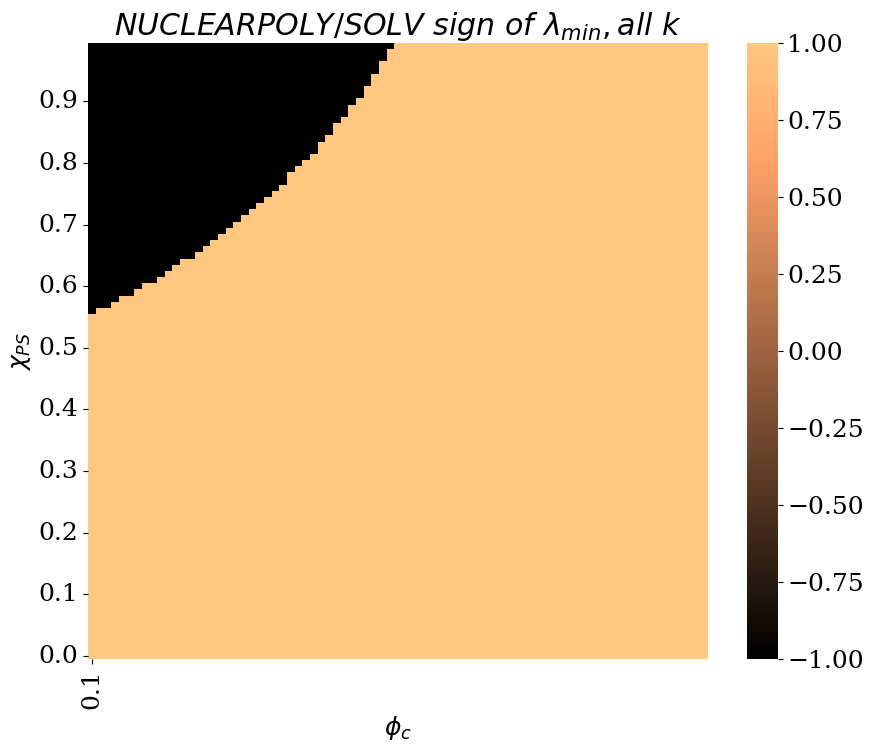

In [121]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_ps), linewidth=0.0, cmap = "copper", xticklabels=np.round(phi_c_array,2), yticklabels=np.round(chi_array,3))# yticklabels=mu1_array,\
#                                 vmin=-1, vmax=1)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::100])
ax.set_xticklabels(np.round(phi_c_array[::100],3))
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(np.round(chi_array[::10],3))
ax.invert_yaxis()
plt.ylabel("$\chi_{PS}$")
plt.xlabel("$\phi_c$")
plt.title(r"$ NUCLEAR POLY/SOLV \ sign \ of \ \lambda_{min}, all \ k$")


plt.show()


<Figure size 640x480 with 0 Axes>

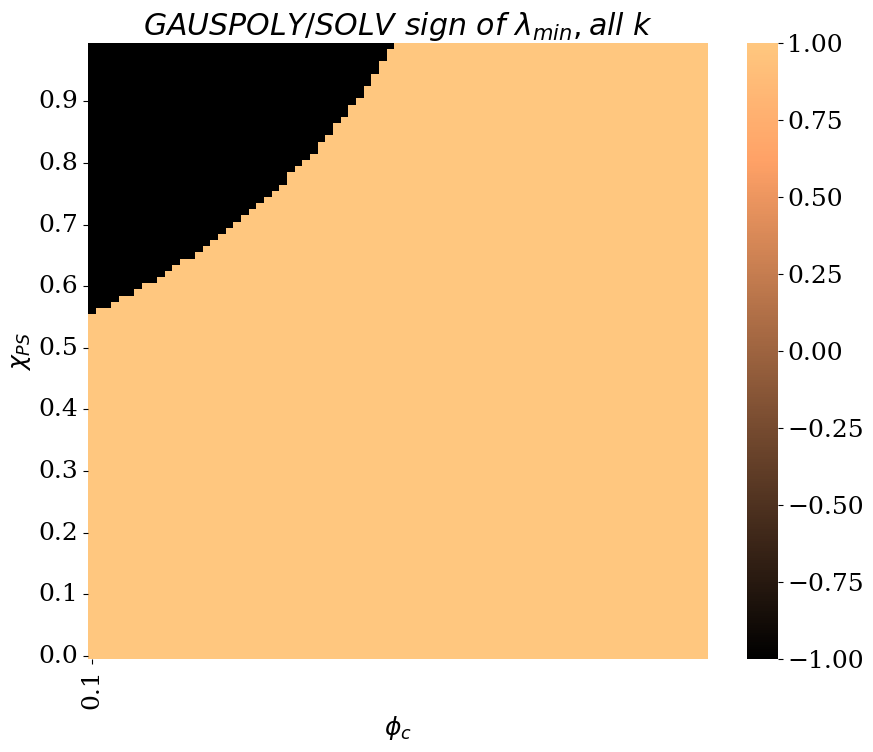

In [122]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_ps_gaus), linewidth=0.0, cmap = "copper", xticklabels=np.round(phi_c_array,2), yticklabels=np.round(chi_array,3))# yticklabels=mu1_array,\
#                                 vmin=-1, vmax=1)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::100])
ax.set_xticklabels(np.round(phi_c_array[::100],3))
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(np.round(chi_array[::10],3))
ax.invert_yaxis()
plt.ylabel("$\chi_{PS}$")
plt.xlabel("$\phi_c$")
plt.title(r"$ GAUS \ POLY/SOLV \ sign \ of \ \lambda_{min}, all \ k$")


plt.show()


In [110]:
# v = np.sign(min_eigval_arr_allk_ps)
# chi_array[np.where(v[:-1] != v[1:])[0]]
# min_eigval_arr_allk_ps[0]
inter(0.4)

array(0.83)

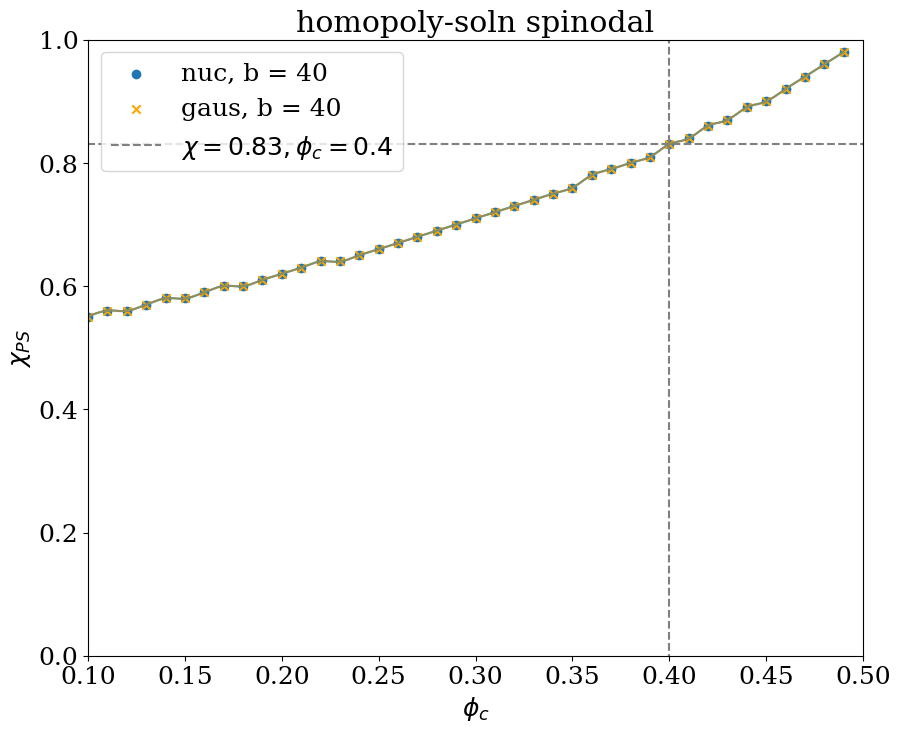

In [127]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
alh = 1

v = np.sign(min_eigval_arr_allk_ps)
spinodal = chi_array[np.where(v[:-1] != v[1:])[0]]

inter = sp.interpolate.interp1d(phi_c_array[:len(spinodal)], spinodal, kind = "quadratic")
max_phi = phi_c_array[:len(spinodal)][-1]
new_x = np.round(np.arange(.1,max_phi,0.0001), 4)#

chi_p4 = inter(0.4)
plt.plot(new_x, inter(new_x))
plt.scatter(phi_c_array[:len(spinodal)], spinodal, label = "nuc, b = " + str(b), linestyle = "-", alpha = alh)


v = np.sign(min_eigval_arr_allk_ps_gaus)
spinodal = chi_array[np.where(v[:-1] != v[1:])[0]]

inter = sp.interpolate.interp1d(phi_c_array[:len(spinodal)], spinodal, kind = "quadratic")
max_phi = phi_c_array[:len(spinodal)][-1]
new_x = np.round(np.arange(.1,max_phi,0.0001), 4)#

chi_p4 = inter(0.4)
plt.plot(new_x, inter(new_x), color = "orange", alpha = 0.5)
plt.scatter(phi_c_array[:len(spinodal)], spinodal, label = "gaus, b = " + str(b), marker = "x", color = "orange" ,alpha = 1)

plt.hlines(chi_p4, 0, 0.5, linestyle = "--", color = "grey", label = r"$\chi = 0.83, \phi_c = 0.4$")
plt.vlines(0.4, -0.1, 1., linestyle = "--", color = "grey")
# plt.text(5, 0.0035, '$k^{-2}$')
# plt.text(5.5, 0.0015, '$k^{-2}$')


plt.title("homopoly-soln spinodal")
plt.ylabel("$\chi_{PS}$")
plt.xlabel("$\phi_c$")
# plt.xlim((1e-3, 1e2))

plt.xlim(.1, .5)
plt.ylim(0, 1)
plt.legend()